In [78]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [79]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [80]:
year='2017'

# Read the histogram from the pickle file
outsum = util.load("outfiles/"+year+"_dask_higgs.coffea")

outsum

{'sumw': defaultdict_accumulator(float,
                         {'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8': 144239460.0,
                          'VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix': 19299380.8125,
                          'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8': 403494.7841796875,
                          'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8': 295614.64453125,
                          'ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8': 4216319.9453125,
                          'ggZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8': 17607.899536132812,
                          'ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8': 382052.77392578125,
                          'WplusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8': 692050.4453125,
                          'WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8': 419587.357421875,
                          'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8': 177231.81640625,
                          'GluGluHToBB_M125_Tun

In [81]:
scale_lumi = {k: 1000 / w for k, w in outsum['sumw'].items()}
outsum['truthpt'].scale(scale_lumi, 'dataset')
pthist = outsum['truthpt'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [82]:
ptbins = np.linspace(400,800,9)

mc_ggf = np.array([pthist.integrate('process','ggF').integrate('ptH',int_range=slice(pt,13000)).values()[()] for pt in ptbins])


mc_vbf = np.array([pthist.integrate('process','VBF').integrate('ptH',int_range=slice(pt,13000)).values()[()] for pt in ptbins])
mc_vh  = np.array([pthist.integrate('process',['WH','ZH']).integrate('ptH',int_range=slice(pt,13000)).values()[()] for pt in ptbins])
mc_tth = np.array([pthist.integrate('process','ttH').integrate('ptH',int_range=slice(pt,13000)).values()[()] for pt in ptbins])

In [83]:
th_ggf = np.array([33.10,18.08,10.17,5.87,3.48,2.13,1.32,0.84,0.54])
th_ggf_unc_up = np.array([10.89,10.78,10.67,10.54,10.35,10.23,10.03,10.05,9.91])*0.01
th_ggf_unc_do = np.array([12.91,12.79,12.74,12.60,12.49,12.45,12.32,12.31,12.24])*0.01

th_ggf_unc_ew = np.zeros(9)

In [84]:
th_vbf = np.array([14.23,8.06,4.75,2.90,1.82,1.17,0.77,0.51,0.35])
th_vbf_unc_up = np.array([0.15,0.23,0.33,0.34,0.41,0.49,0.57,0.69,0.71])*0.01
th_vbf_unc_do = np.array([0.19,0.23,0.29,0.36,0.39,0.39,0.45,0.56,0.60])*0.01
th_vbf_unc_ew = np.array([17.80,19.43,21.05,22.34,23.73,25.03,26.29,27.35,28.42])*0.01

In [85]:
th_vh = np.array([11.16,6.87,4.39,2.87,1.91,1.30,0.90,0.62,0.44])
th_vh_unc_up = np.array([4.12,4.60,4.43,4.44,5.22,4.67,4.15,55.15,5.64])*0.01
th_vh_unc_do = np.array([3.68,3.49,4.04,3.74,4.71,4.28,5.40,4.66,4.13])*0.01
th_vh_unc_ew = np.array([19.05,20.83,22.50,24.07,25.56,26.98,28.30,29.60,30.83])*0.01

In [86]:
th_tth = np.array([6.89,4.24,2.66,1.76,1.11,0.72,0.47,0.32,0.22])
th_tth_unc_up = np.array([12.62,12.84,12.85,14.23,12.99,12.60,11.42,11.53,11.42])*0.01
th_tth_unc_do = np.array([12.97,13.15,13.22,13.93,13.40,13.26,12.74,12.84,13.30])*0.01
th_tth_unc_ew = np.array([6.95,7.75,8.49,9.11,9.91,10.67,11.37,11.94,12.51])*0.01

In [87]:
def process_overlay(mc,th,th_unc_up,th_unc_do,th_unc_ew,name):
    mc_norm = mc/mc[0]*th[0]
    th_norm = th
    
    yerr = [np.multiply(th_norm,th_unc_do),np.multiply(th_norm,th_unc_up)]
    yerr_ew = [np.multiply(th_norm,th_unc_ew),np.zeros(9)]
    
    plt.hist(ptbins,weights=mc_norm,bins=np.linspace(400,850,10),histtype='step',color='deepskyblue',label=name+' MC sample')
    plt.hist(ptbins,weights=th_norm,bins=np.linspace(400,850,10),histtype='step',color='black',label=name+' theory prediction')
    plt.errorbar(x=ptbins+30,y=th_norm,yerr=yerr_ew,marker="",linestyle="",color='red',label='EW corrections')
    
    plt.ylabel("Cross section [fb]")
    plt.xlabel("$p_T$ cut value [GeV]")
    plt.legend()
    
    plt.savefig(year+"_"+name+".pdf")
    plt.savefig(year+"_"+name+".png")
    

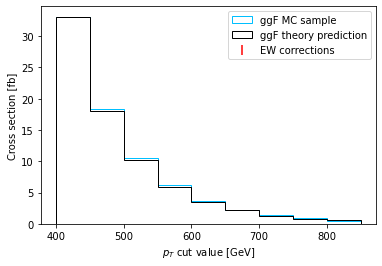

In [88]:
process_overlay(mc_ggf,th_ggf,th_ggf_unc_up,th_ggf_unc_do,th_ggf_unc_ew,'ggF')

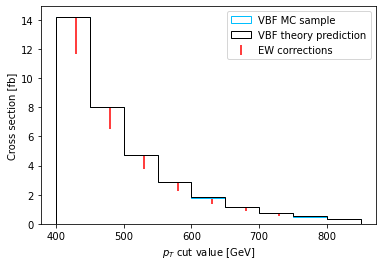

In [89]:
process_overlay(mc_vbf,th_vbf,th_vbf_unc_up,th_vbf_unc_do,th_vbf_unc_ew,'VBF')

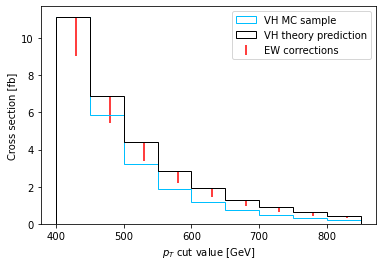

In [90]:
process_overlay(mc_vh,th_vh,th_vh_unc_up,th_vh_unc_do,th_vh_unc_ew,'VH')

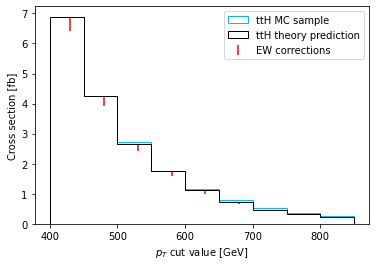

In [91]:
process_overlay(mc_tth,th_tth,th_tth_unc_up,th_tth_unc_do,th_tth_unc_ew,'ttH')